In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.formula.api import ols
import statsmodels.api as sm
import statsmodels.formula.api as smf

from math import sqrt # For Cramer V calculation
from scipy.stats import chi2_contingency # For Cramer V calculation

## 1. Import data

In [2]:
df = pd.read_csv('hotel_booking_case_study.csv')
df.head()

,NRDeposit,IsCanceled,DistributionChannel,MarketSegment,CustomerType,Children,ADR,PreviousCancellations,IsRepeatedGuest,Country,Quarter,Year
0,0,0,Direct,Direct,Transient,0,0.0,0,0,PRT,Q3,2015
1,0,0,Direct,Direct,Transient,0,0.0,0,0,PRT,Q3,2015
2,0,0,Direct,Direct,Transient,0,75.0,0,0,GBR,Q3,2015
3,0,0,Corporate,Corporate,Transient,0,75.0,0,0,GBR,Q3,2015
4,0,0,TA/TO,Online TA,Transient,0,98.0,0,0,GBR,Q3,2015


## 2. Understanding the Relationship of Interest

“Does the type of deposit impact the cancellation rate of bookings?”

In [3]:
# Cancellation rate by deposit types
table_cnt = df.groupby(['NRDeposit','IsCanceled']).agg(cnt = ('Country', lambda x: len(x)))

print(table_cnt)

                        cnt
NRDeposit IsCanceled       
0         0           63316
          1           23042
1         0              55
          1             982


In [5]:
table_pct = table_cnt.groupby(level=0).apply(lambda x:x/float(x.sum()))

print(table_pct)

                           cnt
NRDeposit IsCanceled          
0         0           0.733180
          1           0.266820
1         0           0.053038
          1           0.946962


Here, we can observe that overwhelming majority of bookings have no deposit, with a cancellation rate of about 27%. On the other hand, bookings with nonrefundable deposits (NRDeposit) have a very high cancellation rate.

Behavioral common sense tells us that more likely, the hotels are requesting nonrefundable deposits for “high risk” bookings and there is a confounder.

“A nonrefundable deposit seems to increase cancellation rate, but that relationship is probably confounded by factors we’ll need to determine.”

the best next step would be a randomized experiment: assign refundable or nonrefundable deposits to a random sample of customers and you’ll be able to confirm or disprove your behavioral hypothesis. However, you may not be able to do so, or not yet. In the meantime, we’ll try to deconfound the relationship by identifying relevant variables to include.

## 3. Validate observable variables to include based on data

In [7]:
### Applying Cramer's V
#Formula from https://en.wikipedia.org/wiki/Cram%C3%A9r's_V

def CramerV(var1, var2):
    pivot_tb = pd.crosstab(var1, var2, margins= False)
    chi_sq, _, _, _ = chi2_contingency(pivot_tb)
    n = len(var1)
    k = len(var1.unique())
    r = len(var2.unique())
    V = sqrt((chi_sq/n)/(min(k-1, r-1)))
    return V

V= CramerV(df['NRDeposit'], df['IsCanceled'])
print(V)

0.16483946381640308


## 4. Relations between numeric variables

In [10]:
#Shortening column names
df.rename(columns=
              {"CustomerType": "CustTyp",
               "DistributionChannel": "DistCh",
               "IsRepeatedGuest": "RepGst",
               "MarketSegment": "MktSgmt",
               "IsCanceled": "IsCanc",
               "PreviousCancellations": "PrevCan",
               "NRDeposit": "NRDep"},
              inplace=True)
print(df.columns)

Index(['NRDep', 'IsCanc', 'DistCh', 'MktSgmt', 'CustTyp', 'Children', 'ADR',
       'PrevCan', 'RepGst', 'Country', 'Quarter', 'Year'],
      dtype='object')


In [11]:
#Creating a dataframe with the numerical and binary variables only
num_df = df.copy().select_dtypes(include=['int64', 'float64'])
num_df.columns

Index(['NRDep', 'IsCanc', 'Children', 'ADR', 'PrevCan', 'RepGst', 'Year'], dtype='object')

             NRDep    IsCanc  Children       ADR   PrevCan    RepGst      Year
NRDep     1.000000  0.164958 -0.032703 -0.040040  0.149858 -0.016099 -0.019110
IsCanc    0.164958  1.000000  0.060165  0.133467  0.126891 -0.089640  0.088037
Children -0.032703  0.060165  1.000000  0.339825 -0.028195 -0.047242  0.034155
ADR      -0.040040  0.133467  0.339825  1.000000 -0.073385 -0.161620  0.186587
PrevCan   0.149858  0.126891 -0.028195 -0.073385  1.000000  0.246987 -0.119020
RepGst   -0.016099 -0.089640 -0.047242 -0.161620  0.246987  1.000000  0.024342
Year     -0.019110  0.088037  0.034155  0.186587 -0.119020  0.024342  1.000000


<ipython-input-13-f0fc209ed502>:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask=np.zeros_like(num_corr, dtype=np.bool),


<AxesSubplot:>

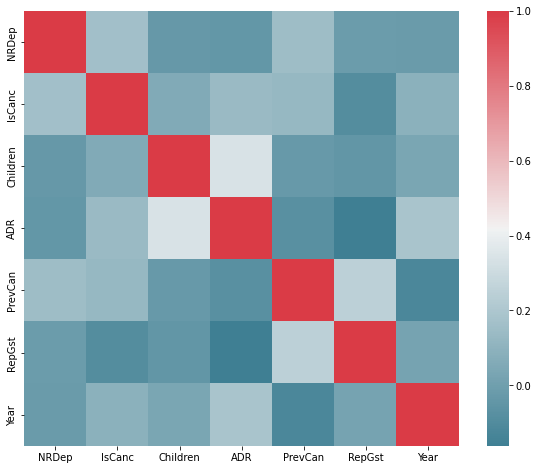

In [13]:
#Creating the correlation matrix for numerical and binary variables only
num_corr = num_df.corr()
print(num_corr)

fig, ax = plt.subplots(figsize = (10, 8))
sns.heatmap(num_corr, 
            mask=np.zeros_like(num_corr, dtype=np.bool), 
            cmap=sns.diverging_palette(220,10, as_cmap=True),
            square=True,
            ax=ax)

The first column indicates the correlations with '*NRDeposit*' and the second column the correlations with '*IsCanceled*'. '_PreviousCancellation_' has correlation coefficients with our variables of interest that are of the same order of magnitude (0.15 and 0.13, respectively). Similarly, '_ADR_' has a correlation coefficient with '_IsCanceled_' that is significant by that criterion (0.13).

## 5. Relationships between categorical variables

In [14]:
#Convert variables to categorical 
num_list = ['NRDep','IsCanc','DistCh','MktSgmt','CustTyp','PrevCan','RepGst','Country','Quarter']

for i in num_list:
    df[i] = pd.Categorical(df[i])

df.dtypes

NRDep       category
IsCanc      category
DistCh      category
MktSgmt     category
CustTyp     category
Children       int64
ADR          float64
PrevCan     category
RepGst      category
Country     category
Quarter     category
Year           int64
dtype: object

VarJ      Country   CustTyp    DistCh    IsCanc   MktSgmt     NRDep   PrevCan  \
VarI                                                                            
Country  0.994589  0.121525  0.174364  0.194173  0.181668  0.149602  0.191032   
CustTyp  0.121525  1.000000  0.088851  0.127065  0.326992  0.010640  0.066364   
DistCh   0.174364  0.088851  1.000000  0.152114  0.734199  0.032245  0.143917   
IsCanc   0.194173  0.127065  0.152114  0.999971  0.220722  0.164839  0.126797   
MktSgmt  0.181668  0.326992  0.734199  0.220722  1.000000  0.283656  0.168677   
NRDep    0.149602  0.010640  0.032245  0.164839  0.283656  0.999512  0.149473   
PrevCan  0.191032  0.066364  0.143917  0.126797  0.168677  0.149473  0.999697   
Quarter  0.110352  0.061455  0.069202  0.071384  0.072494  0.031931  0.060018   
RepGst   0.231452  0.108399  0.353780  0.089574  0.395924  0.015826  0.246773   

VarJ      Quarter    RepGst  
VarI                         
Country  0.110352  0.231452  
CustTyp  0.061455 

<AxesSubplot:xlabel='VarJ', ylabel='VarI'>

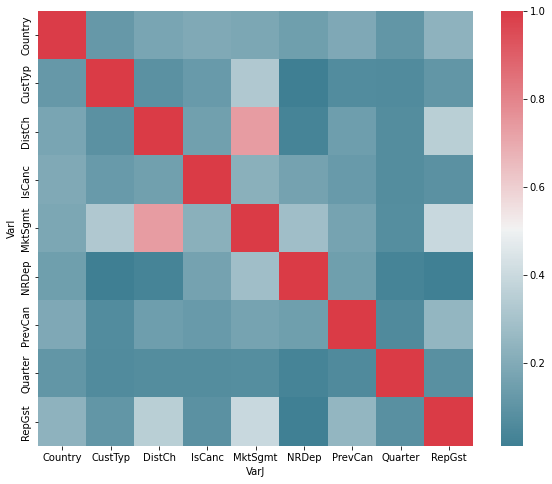

In [21]:
# Calculating correlation matrix for the categorical and binary variables only
def cat_corr_fun(df):

    #Initialize output dataframe
    cat_corr_df = pd.DataFrame(columns=['VarI','VarJ','corr'])

    #Subset to categorical variables only
    cat_df = df.select_dtypes(exclude=['int64', 'float64'])


    for VarI in cat_df.columns:
        for VarJ in cat_df.columns:
            corr = CramerV(cat_df[VarI], cat_df[VarJ])
            row = pd.Series(data = {'VarI':VarI, 'VarJ':VarJ, 'corr':corr})
            cat_corr_df = cat_corr_df.append(row, ignore_index = True)
    return(cat_corr_df)
cat_corr_df = cat_corr_fun(df)
cat_corr = pd.pivot_table(cat_corr_df, index= ['VarI'],columns=['VarJ'], values=['corr'], fill_value=1)

cat_corr.columns = cat_corr.columns.droplevel(0)
print(cat_corr)

fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(cat_corr,cmap=sns.diverging_palette(220,10, as_cmap=True), square=True, ax=ax)

This correlation yields a variety of insights. Looking at the bottom row, we can see that '_Quarter_' is not meaningfully correlated with anything else. This suggests that sea‐ sonality is not a relevant factor for our analysis. Conversely, it is possible that a quarter is too coarse a unit of time and that we need to zoom in on very specific time periods such as the Christmas holidays. We can drop '_Quarter_' from our CD and replace it with an unobserved variable Seasonality as a cue for future research.

Our three variables for customer segments, '_CustomerType_', '_MarketSegment_', and '_DistributionChannel_', show a mixed pattern, with some very strong and some weak corre‐ lations between them. Similarly, their correlations with other variables are all over the place: all three of them have correlations with Country in the 0.1X digits for example, but two of them have high correlations with '_RepeatedGuest_' (0.35 and 0.4) whereas the third one has a correlation of only 0.11. This suggests that these variables are not just interchangeable, but that they are capturing some aspects of the same behaviors. This calls for further investigation and most likely creating new variables.

### 6. Correlations between numeric and categorical variables